# Visión por Computador - Práctica 1 - Filtrado de Imágenes

#### 12 puntos   |   Fecha de entrega: 03 de Noviembre, 23:59   |   Forma de entrega: a través de la tarea creada en https://pradogrado2425.ugr.es/

### Estudiante: CARMEN AZORÍN MARTÍ



---

## Normas de entrega

1. Para este trabajo, al igual que para los demás, se debe presentar código, resultados, discusión de los mismos, y presentación y análisis del trabajo realizado, todo integrado en el propio Google Colab Notebook (es decir, no se entrega ninguna memoria separada en `.pdf` ni ningún código `.py`). Se recuerda que código y resultados sin informe explicativo no puntúa.

2. En relación con el punto anterior, solo se acepta la entrega de ficheros `.ipynb` (no resulta válido entregar un fichero `.py`).

3. El diseño de celdas del documento debe ser respetado.

4. Solo se entregará el fichero `.ipynb` (incorporando código, resultados, y explicación del trabajo realizado y los resultados obtenidos) y no se enviarán las imágenes empleadas.

5. El path para la lectura de imágenes, o cualquier otro fichero de entrada, debe ser siempre “/content/drive/My Drive/images/nombre_fichero”

6. El código deberá  presentarse adecudamente comentado y con los resultados obtenidos en cada apartado, junto con la presentación del trabajo realizado y la discusión y análisis de los resultados obtenidos. Es importante reiterar que la entrega de código sin informe explicativo o valoraciones no puntúa. Por otro lado, el código debe ir comentado en comentarios en celdas de código, mientras que el análisis y discusión, tanto del trabajo realizado como de los resultados obtenidos, debe ir en celdas de texto.

Este trabajo de implementación tiene como objetivo principal **familiarizarse con la implementación y uso de filtros de convolución, así como del cálculo de las derivadas de una imagen y sus posibles aplicaciones**.








---



## Funciones de apoyo y conexión con Google Drive

In [1]:
# We start by getting access to the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# We import the modules to use
import os,sys
import cv2, numpy as np, math
from matplotlib import pyplot as plt
# change directory
%cd '/content/drive/My Drive'
#  the current directory
%pwd

# This allows to display images  and to save  them in cells
%matplotlib inline
# this definition allows to read files in a specific path
get_image = lambda route: os.path.join('/content/drive/My Drive/images', route)

/content/drive/My Drive


Las funciones que se incluyen a continuación, se proporcionan como ayuda/apoyo para el estudiante. **En caso de que el alumnado prefiera utilizar otras funciones para lectura, normalización y visualización de imágenes, tiene total libertad para hacerlo, pero sí debe justificar y explicar razonadamente el motivo de dicho cambio y describir las modificaciones realizadas.**

Recuérdese que todas las imágenes a emplear durante las prácticas de todo el curso se pueden encontrar en el enlace de Google Drive indicado en PRADO: https://pradogrado2425.ugr.es/mod/url/view.php?id=91457 En concreto, https://drive.google.com/drive/folders/1UtvY8q6w1Cz9a9T9zxIqSweoRLgNwoW-

In [3]:
'''
This function receives a string with the filename of the image to read,
and a flag indicating if we want to read it in color/RGB (flagColor=1) or gray level (flagColor=0)

Example of use:
im1=readIm(get_image('apple.jpg'),0)

'''
def readIm(filename, flagColor=1):
  # cv2 reads BGR format
  im=cv2.imread(filename)
  # change to  RGB and return the image
  if(flagColor):
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  # change from BGR to grayscale instead if flag is 0
  return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

In [4]:
'''
This function receives an array of arbitrary real numbers (that could include even negative values),
and returns an 'image' in the range [0,1].
flag_GLOBAL allows the user to normalize the whole image (including all channels) or to normalize
each channel/band independently.
'''
def rangeDisplay01(im, flag_GLOBAL= True):
  im = im.astype(float)
  if flag_GLOBAL:
    im = (im - im.min())/(im.max() - im.min())
  else:
    # bands normalization
    for band in range(im.shape[2]):
      im[:, :, band] = (im[:, :, band] - im[:, :, band].min())/(im[:, :, band].max() - im[:, :, band].min())
      # Note: remember that, for plt.imshow with RGB data, the valid range is [0..1] for floats and [0..255] for integers.
  return im

In [5]:
'''
This function displays a single image, including a title, using a magnification factor.

Example of use:
im1=readIm(get_image('apple.jpg'),0)
displayIm(im1,'Manzana',0.5)

'''
def displayIm(im, title='Result',factor= 2):
  # First normalize range
  max=np.max(im)
  min=np.min(im)
  if min<0 or max>255:
    im=rangeDisplay01(im,flag_GLOBAL=True)
  if len(im.shape) == 3:
    # im es tribanda
    plt.imshow(im, cmap='jet')
  else:
    # im es monobanda
    plt.imshow(im, cmap='gray')
  figure_size = plt.gcf().get_size_inches()
  plt.gcf().set_size_inches(factor * figure_size)
  plt.title(title)
  plt.xticks([]), plt.yticks([]) # eliminamos numeración
  plt.show()

In [6]:
'''
This function displays multiple images (including a title and using a magnification factor)
of equal size. The input to the function is a list of images.

Example of use:
im1=readIm(get_image('apple.jpg'),1)
images = [im1,im1,im1]

displayMI_ES(images, title='Manzanas',factor=1)

IMPORTANT NOTE: it is important to notice that this function stacks all images
and later call displayIm(). This implies that the normalization (rangeDisplay01()) is done
at the very end of the process. As a consequence, if the stacked images have different
range values they can be displayed in a "weird" way (with black regions (pixel value = 0)
looking grey). In case the visualization seems to be a problem, a possible solution
would be to create vim using vim.append(rangeDisplay01(...)). In this way, all images
would be on the same range of values (negative values around 0 (black),
0 values around 0.5 (grey), and positive values closer to 1 (white))

'''
def displayMI_ES(vim, title='Result',factor=2):
  # We set the maximun number of images to concatenate by columns
  maxcolumns=3
  # number of images to display
  numberim=len(vim)
  # The simplest case, one row: the maximum number of columns is larger than the images to stack
  # This is, by default, we put together the images column-wise
  if len(vim) < maxcolumns:
    out=vim[0]
    for item in range(1,len(vim)):
      #displayIm(out,str(item),1)
      out=np.hstack((out,vim[item]))

  # Else, if maxcolumns is smaller or equal than the number of images to stack
  else:
    # We check if all rows and columns are going to be 'busy', or if otherwise we need an extra-row
    if np.mod(len(vim),maxcolumns)== 0:
      maxrows=numberim//maxcolumns
    else:
      maxrows=numberim//maxcolumns+1

    # we build up the first block-row
    out=vim[0]
    for item in range(1,maxcolumns):
      out=np.hstack((out,vim[item]))
    # We build up the rest of block-rows
    for block in range(1,maxrows):
      #print(block)
      row=vim[block*maxcolumns]
      for item in range(1,maxcolumns):
        # We still have images to stack
        if block*maxcolumns+item < numberim:
          row=np.hstack((row,vim[block*maxcolumns+item]))
        # We do not have more images, and we have to fill with black
        else:
          row=np.hstack((row,np.zeros(vim[0].shape,dtype=vim[0].dtype)))
          #print(row.dtype)
          # if we don't include ',dtype=vim[0].dtype', np.zeros will include float
          # numbers in the matrix. This will make that the whole matrix will be
          # considered as floats, and values larger than 1 will be clipped to 1,
          # displaying an almost totally white image
      # add the new block-row
      out=np.vstack((out,row))
  return displayIm(out,title,factor)

# **Ejercicio 1: discretización de máscaras y filtrado Gaussiano** (6 puntos)

En este ejercicio aprenderemos a discretizar máscaras de convolución y a aplicarlas sobre imágenes empleando funciones de OpenCV. También buscamos hacerlo de un modo eficiente, y es por ello que, en toda la práctica, se exige el uso de convoluciones 1D (separables).





## A) (1.5 puntos)

En este apartado se deben realizar las siguientes tareas:

1. Calcular las máscaras discretas 1D de la Gaussiana, así como su primera y segunda derivadas (normalizadas), considerando que la entrada a dicha función de creación de máscaras 1D puede ser tanto un posible sigma como un posible tamaño de máscara.
2. Emplear los siguientes valores de sigma ($\{1, 1.5, 2.5, 6\}$) y los siguientes valores de tamaño de máscara ($\{7, 11, 15\}$), y mostrar el perfil (es decir, la silueta de las máscaras como funciones 1D) para verificar que las máscaras creadas son correctas.
3. Describir/explicar/analizar si las formas de dichos kernels tienen sentido y se corresponden con lo que esperaríamos ver.

# Cómo se calcula GaussFunc, GuassDeriv1Func y GaussDeriv2Func
La función gaussiana viene dada por:

<center> $g(x)= e^{f(x)}$</center>

donde

<center>$f(x)=-x²/2\sigma²$ </center>

Para la derivada necesitaremos la derivada de $f$ con respecto de $x$:

<center>$f'(x) = -x/\sigma² \implies g'(x)=f'(x)e^{f(x)}=f'(x)g(x)$ </center>

Finalmente, la segunda derivada se calcula aplicando la regla de la cadena en la primera derivada:

<center>$g''(x)=f''(x)g(x)+f'(x)g'(x)=$

  $=f''(x)g(x)+f'(x)f'(x)g(x)=$

  $= f''(x)g(x)+f'(x)²g(x) = g(x)(f''(x)+f'(x)²)$ </center>

donde

<center>$f''(x)=-1/\sigma²$

 $f'(x)²=x²/\sigma⁴$</center>


# Cómo se calcula gaussianMask1D
La máscara Gaussiana 1D es un vector de la forma:
<center>$[f(-k),f(-k+1),...,f(0),f(1),...,f(k)]$</center>

Donde $f$ depende del parámetro _order_ : para 0, $f$ es la función Gaussiana; para 1, $f$ es su primera derivada; y para 2, $f$ es su segunda derivada.

Y $k$ es el menor entero que verifica que
<center>$k>=3\sigma$</center>

En caso de que $\sigma=0$, $k$ dependerá del parámetro _sizeMask_ , cumpliendo la fórmula:
<center>$k=(sizeMask-1)/2$</center>

Para encontrar ese $k$ se ha creado la funcion _findMink_ , con un bucle que deja de buscar en el momento en el que la fórmula anterior se cumple. También podremos calcular $\sigma$ correspondiente:
<center>$\sigma = (sizeMask-1)/6$</center>

Una vez tengamos $\sigma$ y $k$, podremos calcular la máscara aplicando la función correspondiente al vector $[-k,...,k]$ dado por _np.linspace(-k,k,sizeMask)_.

Antes de devolver la máscara, hay que recordar dividir los elementos entre la suma de sus coeficientes, siempre y cuando la función sea la Gaussiana original. De esta forma, todos los valores de la máscara sumara

En el caso de las derivadas, todos los valores de la máscara suman 0. En cuanto a la Gaussiana original, deberemos normalizarla diviendo entre la suma de los coeficientes, así la suma de la máscara será 1.


In [7]:
def GaussFunc(xaxis,sigma):
    f = lambda x: -(x*x)/(2*sigma*sigma)
    g = lambda x: math.exp(f(x))
    return list(map(g, xaxis))

def GaussDeriv1Func(xaxis,sigma):
    f = lambda x: -(x*x)/(2*sigma*sigma)
    derivf = lambda x: -x/(sigma*sigma)
    derivg = lambda x: math.exp(f(x))*derivf(x)
    return list(map(derivg,xaxis))

def GaussDeriv2Func(xaxis,sigma):
    f = lambda x: -(x*x)/(2*sigma*sigma)
    derivf2 = lambda x: x*x/(sigma*sigma*sigma*sigma)
    deriv2f = lambda x: -1/(sigma*sigma)
    deriv2g = lambda x: (deriv2f(x)+derivf2(x))*math.exp(f(x))
    return list(map(deriv2g,xaxis))

def findMink(sigma):
    k = 0
    # el bucle para cuando encuentre el primer entero k tal que k >= 3*sigma
    while 3*sigma > k:
      k = k+1
    return k

def gaussianMask1D(sigma=0, sizeMask=0, order=0):
    # order = 0 -> función Gaussiana
    # order = 1 -> derivada de la Gaussiana
    # order = 2 -> derivada segunda de la Gaussiana
    if order == 0:
      func = GaussFunc
    elif order == 1:
      func = GaussDeriv1Func
    elif order == 2:
      func = GaussDeriv2Func

    # calculamos k y el parámetro que falte: sigma o sizeMask
    if sigma != 0:
      k = findMink(sigma)
      sizeMask = 2*k+1
    else:
      k = (sizeMask-1)/2
      sigma = (sizeMask-1)/6
    # aplicamos la función correspondiente a todos los valores de [-k,...,k]
    mask = func(np.linspace(-k,k,sizeMask),sigma)
    # la máscara debe sumar 1 -> dividimos entre la suma de los coeficientes.
    if order == 0:
      sum = np.sum(mask)
      mask = list(map(lambda x: x/sum, mask))
    return mask

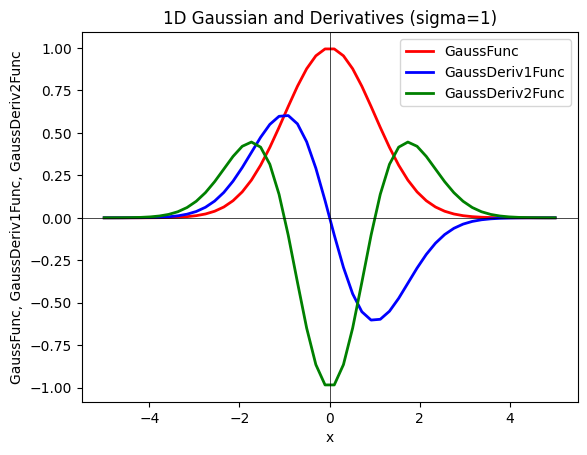

In [ ]:
# Con la siguiente figura verificamos que las funciones Gaussianas implementadas son correctas
plt.figure()
xvalues = np.linspace(-5, 5)
yvalues1 = GaussFunc(xvalues,1)
yvalues2 = GaussDeriv1Func(xvalues,1)
yvalues3 = GaussDeriv2Func(xvalues,1)
plt.plot(xvalues, yvalues1, lw=2, color='red',
label='GaussFunc')
plt.plot(xvalues, yvalues2, lw=2, color='blue',
label='GaussDeriv1Func')
plt.plot(xvalues, yvalues3, lw=2, color='green',
label='GaussDeriv2Func')
plt.title('1D Gaussian and Derivatives (sigma=1)')
plt.xlabel('x')
plt.ylabel('GaussFunc, GaussDeriv1Func, GaussDeriv2Func')
plt.axhline(0, lw=0.5, color='black')
plt.axvline(0, lw=0.5, color='black')
plt.legend();

# Cómo representar el perfil

Primero representaremos 9 gráficas, en una cuadrícula 3x3.

Iteramos primero por filas y luego por columnas.
- Cada fila representa un tamaño de máscara y el $\sigma$ que le corresponde
- Cada columna identifica el orden de la función

Para calcular la máscara se llama a la función _gaussianMask1D_ con parámetro $\sigma = 0$, para que se calcule automáticamente. Y asignamos esa máscara a la gráfica que le corresponde.

A continuación representaremos 12 gráficas, en una cuadrícula 4x3.

- Cada fila representa un valor de $\sigma$
- Cada columna identifica el orden de la función

Para calcular la máscara se llama a la función _gaussianMask1D_ con parámetro $sizeMask = 0$, para que se calcule automáticamente. Y asignamos esa máscara a la gráfica que le corresponde.

También usamos _autoscale_ para que se ajusten los ejes $x$ e $y$.

FIJAMOS PRIMERO EL TAMAÑO DE LA MÁSCARA


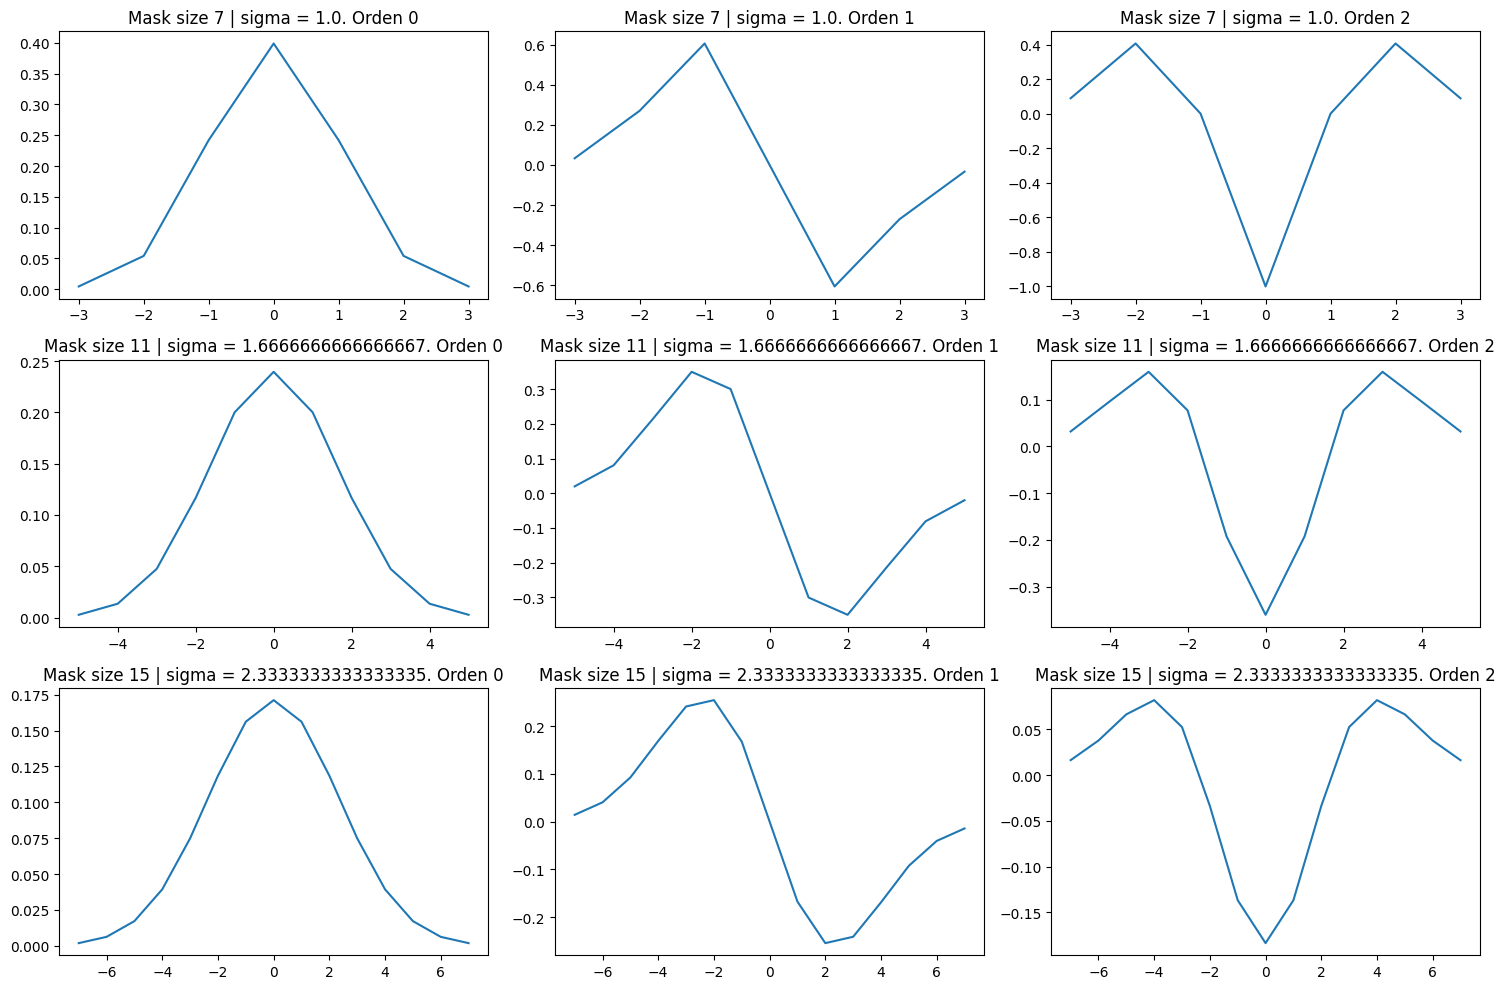

FIJAMOS AHORA EL SIGMA


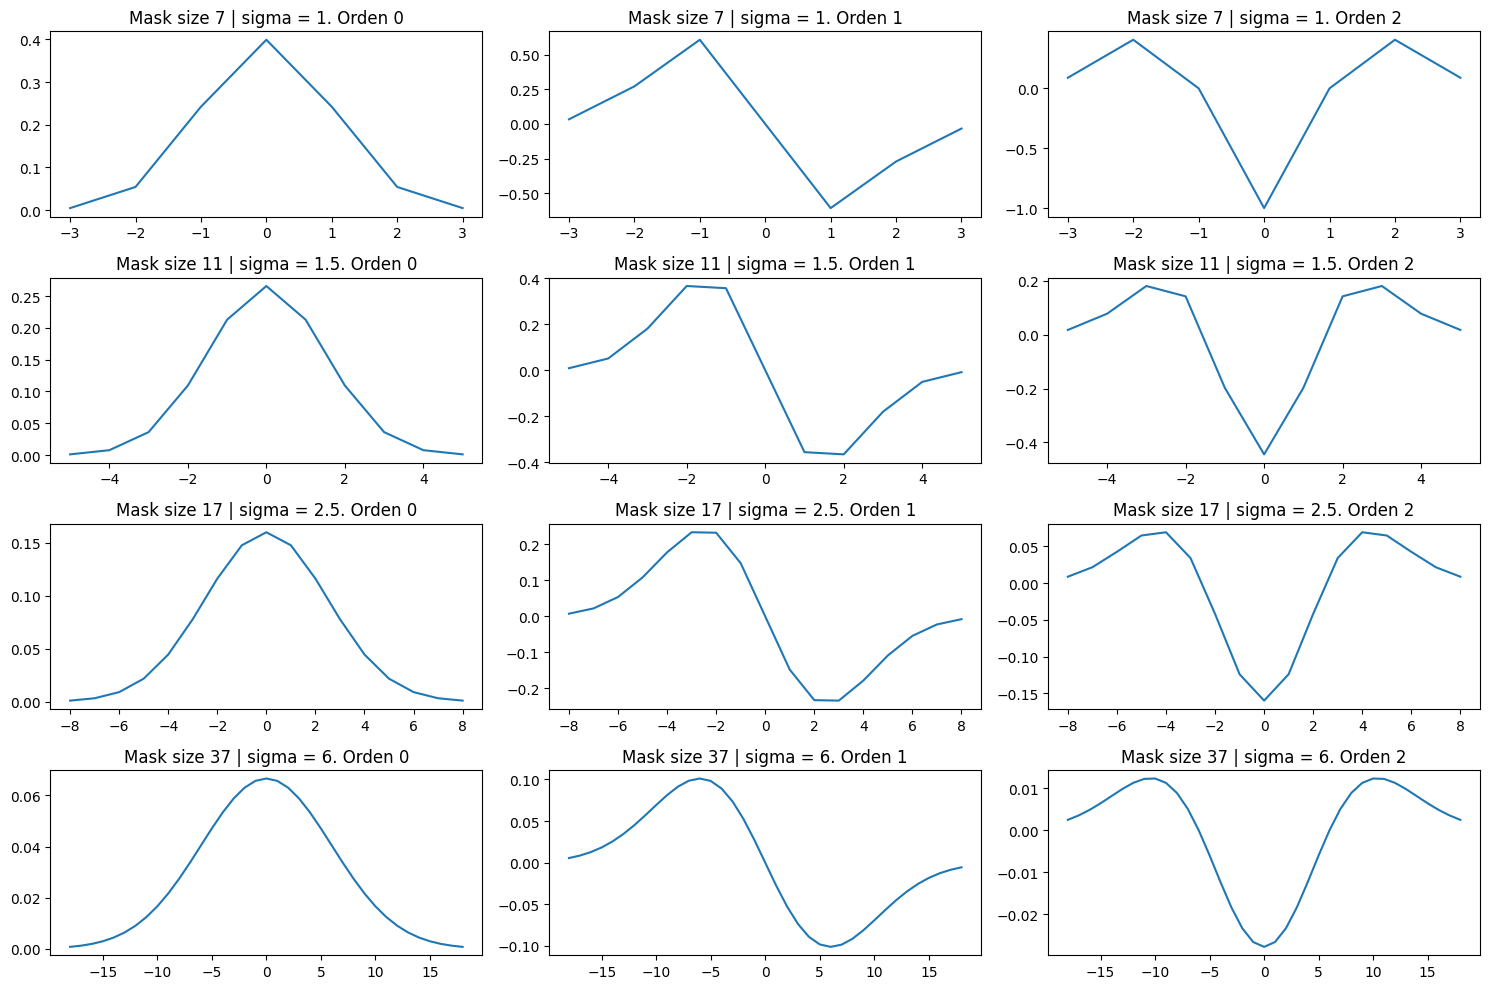

In [ ]:
sigma_values = [1,1.5,2.5,6]
size_masks = [7,11,15]

fig, axes = plt.subplots(3, 3, figsize=(15,10))
#plt.rcParams["figure.figsize"] = (15,3) # para ajustar tamaño del ancho y alto (ejes)
print('FIJAMOS PRIMERO EL TAMAÑO DE LA MÁSCARA')

for i in range(0,3):
  sizeMask = size_masks[i]
  for j in range(0,3):
    xaxis = np.linspace(-(sizeMask-1)/2,(sizeMask-1)/2,sizeMask)
    mask = gaussianMask1D(0,sizeMask,j)
    sigma = (sizeMask-1)/6
    axes[i,j].plot(xaxis,mask)
    axes[i,j].set_title('Mask size {} | sigma = {}. Orden {}'.format(sizeMask, sigma,j))
    axes[i,j].autoscale()
fig.tight_layout()
plt.show()

fig, axes = plt.subplots(4, 3, figsize=(15,10))
print('FIJAMOS AHORA EL SIGMA')
for i in range(0,4):
  sigma = sigma_values[i]
  for j in range(0,3):
    k = findMink(sigma)
    xaxis = np.linspace(-k,k,2*k+1)
    mask = gaussianMask1D(sigma,0,j)
    axes[i,j].plot(xaxis,mask)
    axes[i,j].set_title('Mask size {} | sigma = {}. Orden {}'.format(2*k+1, sigma,j))
    axes[i,j].autoscale()
fig.tight_layout()
plt.show()


## B) (1.5 puntos)

En este apartado se debe leer una imagen en escala de grises (`'zebra.jpg'`) y esta debe ser filtrada mostrando el resultado de la convolución con una Gaussiana, con la primera derivada de la Gaussiana (tanto en $X$ como en $Y$), y con la segunda derivada de la Gaussiana (tanto en $X$ como en $Y$). Para ello, hay que:
1. emplear los siguientes sigmas ($\{0.75,1,2,4,8, 16\}$),
2. usar la función de OpenCV `sepFilter2D()` con las máscaras calculadas a partir de las funciones desarrolladas en el apartado anterior,
3. mostrar todas las imágenes dentro del mismo canvas, tal y como se muestra más abajo,
4. analizar los resultados obtenidos y discutir si se corresponden con lo se esperaría obtener en base a nuestro conocimiento de la teoría.




In [16]:
def my2DConv(im, sigma, orders):
  maskG = np.array(gaussianMask1D(sigma,0,0))
  maskG1 = np.array(gaussianMask1D(sigma,0,1))
  maskG2 = np.array(gaussianMask1D(sigma,0,2))
  if orders==[0,0]: # Suavizado Gaussiano
    return cv2.sepFilter2D(im,cv2.CV_64F,maskG,maskG)
  elif orders==[0,1]:
    return cv2.sepFilter2D(im,cv2.CV_64F,maskG,maskG1)
  elif orders==[1,0]:
    return cv2.sepFilter2D(im,cv2.CV_64F,maskG1,maskG)
  elif orders==[0,2]:
    return cv2.sepFilter2D(im,cv2.CV_64F,maskG,maskG2)
  elif orders==[2,0]:
    return cv2.sepFilter2D(im,cv2.CV_64F,maskG2,maskG)
  else:
    print('error in order of derivative')

sigmas = [0.75,1,2,4,8,16]


im=cv2.imread(get_image('zebra.jpg'),0)

for i in range(0,3):
  vim0=[]
  orders=[0,i]
  for sigma in sigmas:
    vim0.append(rangeDisplay01(my2DConv(im,sigma,orders),True))
  displayMI_ES(vim0,'Zero derivative [0,{}]'.format(i),2)
  vim0=[]
  orders=[i,0]
  for sigma in sigmas:
    vim0.append(rangeDisplay01(my2DConv(im,sigma,orders),True))
  displayMI_ES(vim0,'Zero derivative [{},0]'.format(i),2)



Output hidden; open in https://colab.research.google.com to view.

## C) (1 punto)

En este apartado hay que emplear la función de OpenCV `sepFilter2D()` con $\sigma=2.0$ para calcular y mostrar el gradiente (4 imágenes: derivada en $X$, derivada en $Y$, magnitud y orientación) y la Laplaciana de la Gaussiana. Se debe explicar el trabajo realizado, incluyendo las expresiones matemáticas subyacentes y el análisis, al igual que en todos los ejercicios, relativo a si los resultados obtenidos se corresponden con lo esperado.

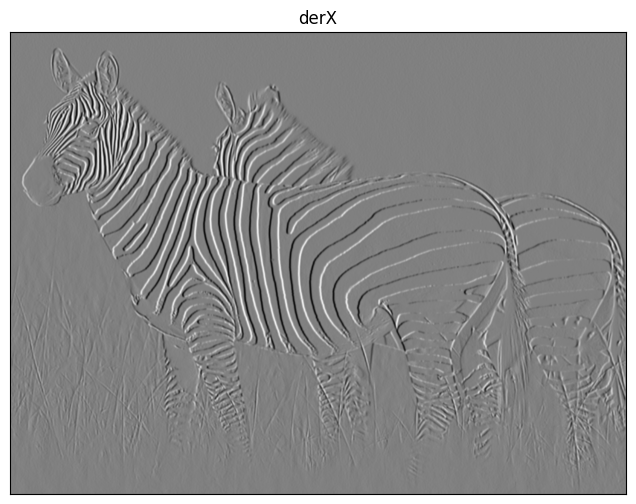

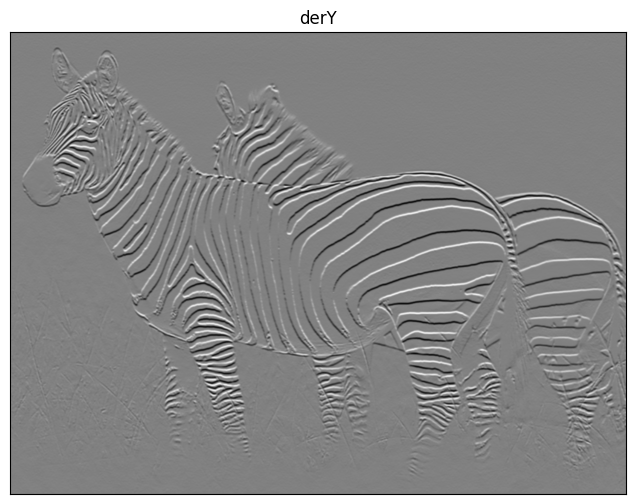

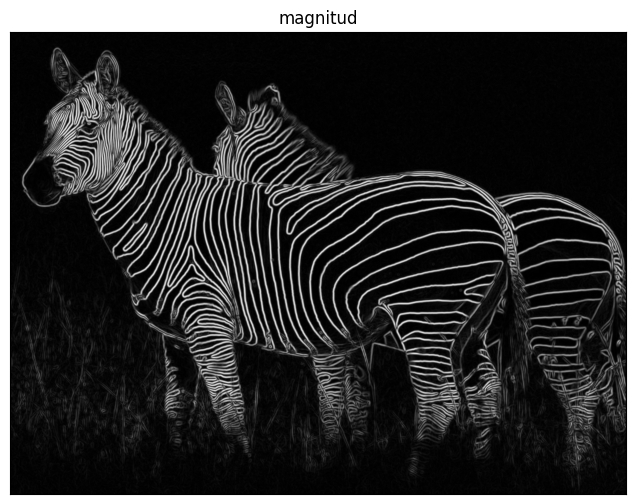

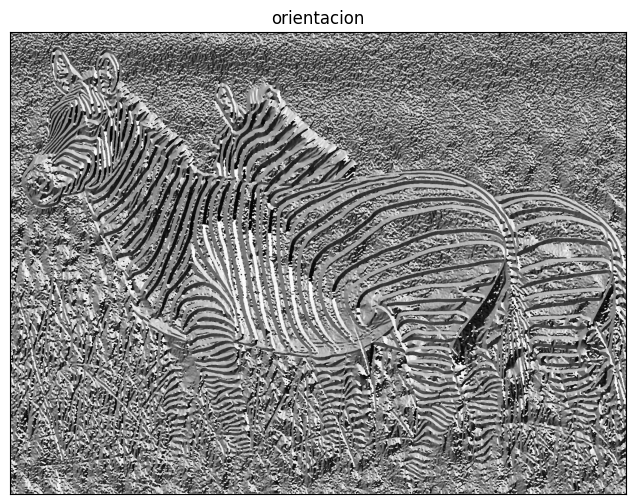

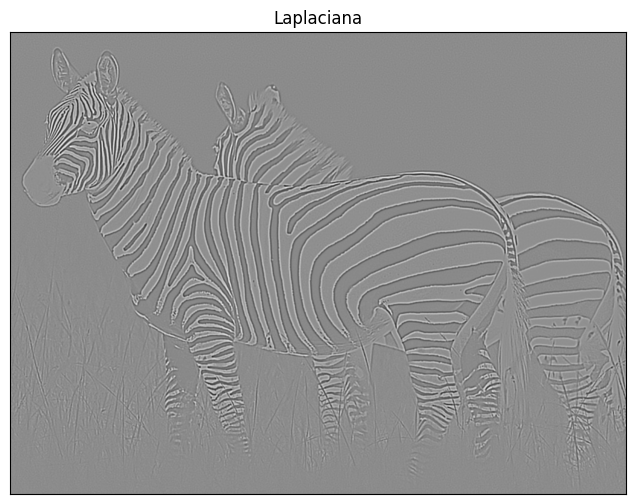

In [ ]:
def gradientIM(im,sigma):
  #A CUBRIR POR EL ALUMNADO
  return dx,dy

def laplacianG(im,sigma):
  return #A CUBRIR POR EL ALUMNADO

#A CUBRIR POR EL ALUMNADO



## D) (1.5 puntos)

Implemente una función para realizar "a mano" la convolución separable (es decir, empleando kernels 1D). Dicha función debe recibir como entrada una imagen (con el _padding_ adecuado, en caso de que lo necesite, ya incorporado) y un kernel 1D, y debe proporcionar como salida la imagen convolucionada con el kernel en ambas direcciones.

Una vez haya implementado la función, realice el suavizado de la imagen `motorcycle.bmp` (usando un _Gaussian kernel size_ de 7, y dejando que sea la propia función de creación del kernel la que determine el $\sigma$ adecuado), y compare el resultado con el de `cv2.GaussianBlur` (en donde se debe optar por la misma estrategia: fijando $ksize=7$ y dejando que sea la propia función de OpenCV la que escoja el sigma). ¿Hay diferencias (sea a nivel de resultado final o de tiempo de ejecución)? En caso afirmativo, ¿a qué se pueden deber?

In [ ]:
def convolve1D(image,kernel):
    #A CUBRIR POR EL ALUMNADO
    return output

def convolve2D(image, kx, ky):
    #A CUBRIR POR EL ALUMNADO

    return #A CUBRIR POR EL ALUMNADO

In [ ]:
filename = 'motorcycle.bmp'
#A CUBRIR POR EL ALUMNADO

## E) (0.5 puntos)

Las herramientas de IA generativa son de gran utilidad tanto para estudiantes como para docentes. No obstante, resulta fundamental tener una actitud crítica y asumir desde el principio que las respuestas proporcionadas por estas herramientas pueden ser factualmente incorrectas (véase,  por ejemplo, https://elpais.com/tecnologia/2024-09-25/los-nuevos-modelos-de-ia-como-chatgpt-persiguen-la-superinteligencia-pero-no-logran-ser-fiables-ni-en-preguntas-bobas.html). En este sentido, vale la pena recordar lo que indica la guía de la UGR (https://ceprud.ugr.es/formacion-tic/inteligencia-artificial): _"Debes revisar siempre la salida que genera y las posibles referencias que utilice. [...] Mejora tus resultados con la IAGen aprendiendo a usarla y a comunicarte con ella de manera adecuada. Pero no dejes que piense por ti."_

En este apartado trabajaremos de forma crítica la utilidad de estas herramientas. Para ello, el alumnado debe emplear ChatGPT (https://chatgpt.com/) para consultar _"en qué consiste y para qué sirve la normalización de escala, así como por qué, en dicha normalización de escala, se multiplica por $\sigma^n$, siendo $n$ el orden de derivada"_. No se trata meramente de copiar lo que indique ChatGPT como salida, sino de analizar y matizar su respuesta, confrontándola con otras lecturas y lo que el estudiante sabe de la teoría, indicando en qué aspectos dicha respuesta puede considerarse correcta y en qué aspectos quizás no lo es.

# **Ejercicio 2**:  Pirámides Gaussianas y Laplacianas (3.5 puntos)







## A) (1.5 puntos)

Construya una pirámide Gaussiana de 4 niveles empleando máscaras Gaussianas de tamaño $7\times7$. No se permite emplear las funciones `pyrUp()` y `pyrDown()` de OpenCV, ni tampoco `cv2.resize()`.

In [ ]:
'''
This function displays a pyramid of images, providing as input the list of images to display.

Example of use:
im1=readIm(get_image('apple.jpg'),1)
images = [im1, cv2.resize(im1,(im1.shape[0]//2,im1.shape[1]//2),cv2.INTER_LINEAR), cv2.resize(im1,(im1.shape[0]//4,im1.shape[1]//4),cv2.INTER_LINEAR), cv2.resize(im1,(im1.shape[0]//8,im1.shape[1]//8),cv2.INTER_LINEAR), cv2.resize(im1,(im1.shape[0]//16,im1.shape[1]//16),cv2.INTER_LINEAR)]

displayPyramid(images, title='Piramide de Manzanas')

'''
def displayPyramid(vim, title='result'):
  temp = np.zeros_like(vim[0])
  if np.mod(temp.shape[1],2)==0:
    h = temp[:, :temp.shape[1]//2]
  else:
    h = temp[:, :(temp.shape[1]//2)+1]
  out = np.hstack((temp, h))
  top = 0
  out[0:vim[0].shape[0], 0:vim[0].shape[1]] = vim[0]
  left = vim[0].shape[1]
  for i in range(1, len(vim)):
    out[top:top+vim[i].shape[0], left:left + vim[i].shape[1]] = vim[i]
    top += vim[i].shape[0]
  displayIm(out, title)

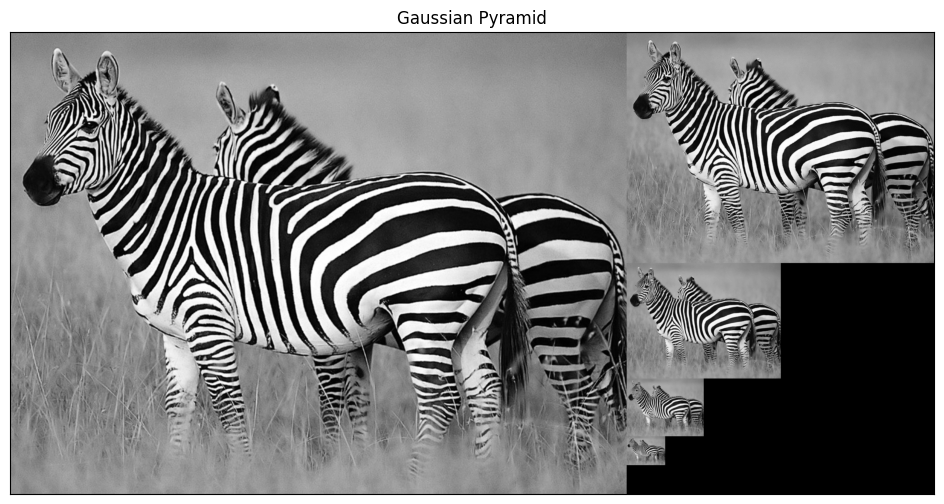

In [ ]:
def pyramidGauss(im,sizeMask=7, nlevel=4):
  #A CUBRIR POR EL ALUMNADO
  return #A CUBRIR POR EL ALUMNADO

im=cv2.imread(get_image('zebra.jpg'),0)
pyrG = pyramidGauss(im,sizeMask=7, nlevel=4)
displayPyramid(pyrG,'Gaussian Pyramid')


## B) (1 punto)

Use su código del apartado anterior para implementar una función que permita construir una pirámide Laplaciana de 4 niveles.

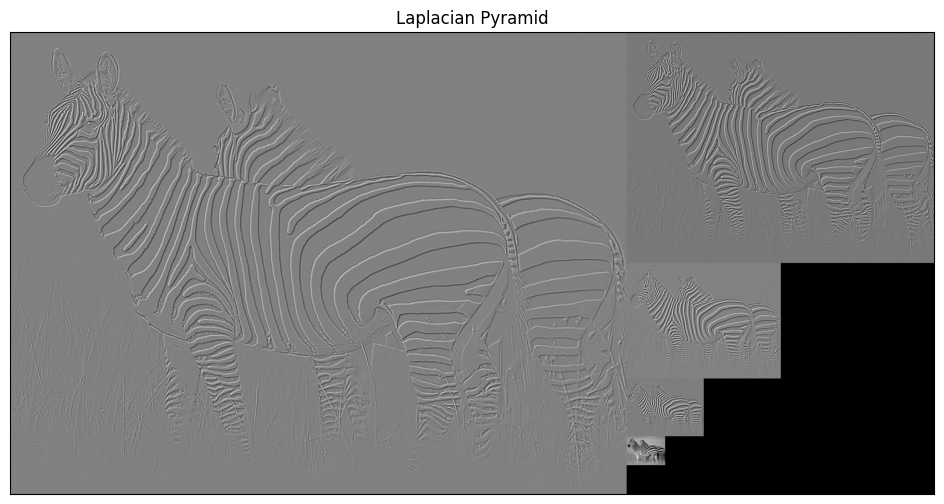

In [ ]:
def pyramidLap(im, sizeMask,nlevel=4,flagInterp=cv2.INTER_LINEAR  ):
  #A CUBRIR POR EL ALUMNADO
  return #A CUBRIR POR EL ALUMNADO

#A CUBRIR POR EL ALUMNADO

## C) (0.5 puntos)

Ahora realice la misma operación que en los apartados anteriores, pero sin suavizar antes de hacer subsampling a la hora de crear la pirámide Gaussiana. ¿Hay diferencias visuales en la pirámide Laplaciana generada? ¿A qué se pueden deber estas?

In [ ]:
#A CUBRIR POR EL ALUMNADO

## D) (0.5 puntos)

Implemente ahora una función para reconstruir la imagen codificada en la pirámide Laplaciana del apartado 2.B. Verifique que es posible obtener una copia exacta de la imagen original. Para ello, calcule el error de reconstrucción como el _Root Mean Squared Error_ (RMSE) entre los niveles de intensidad de la imagen original y la imagen reconstruida.

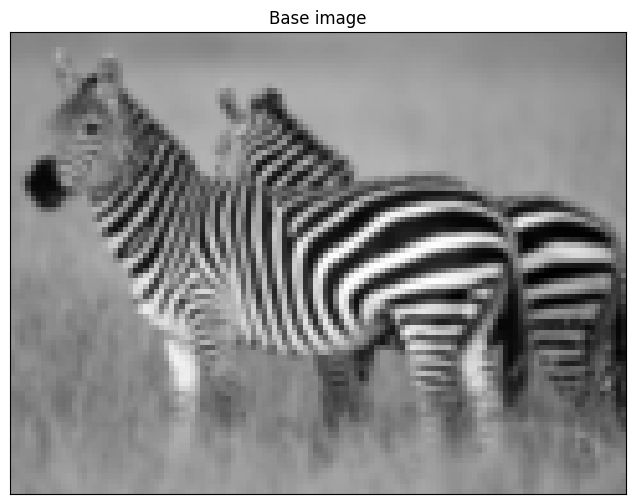

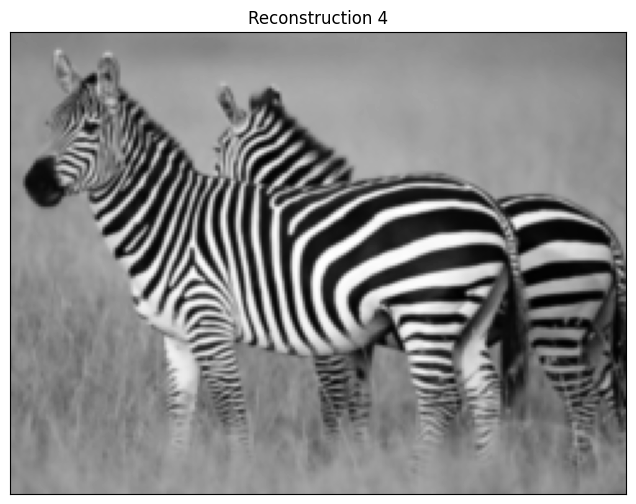

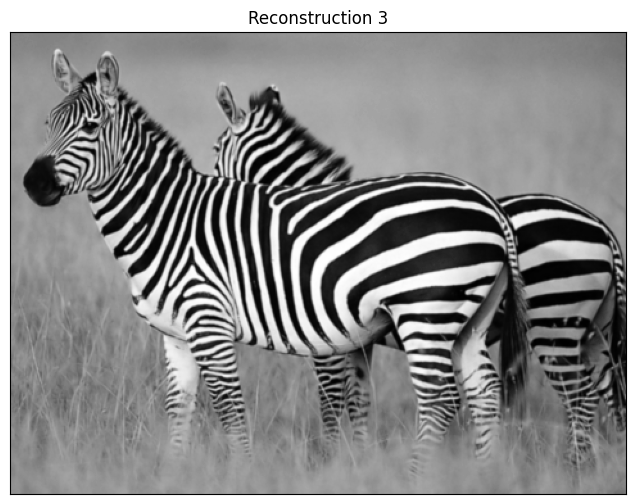

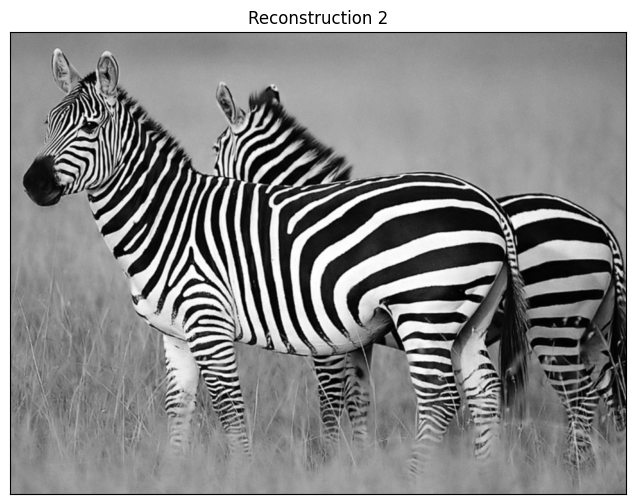

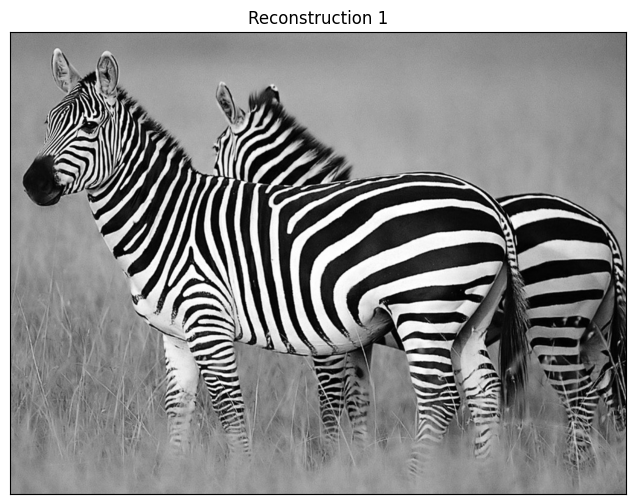

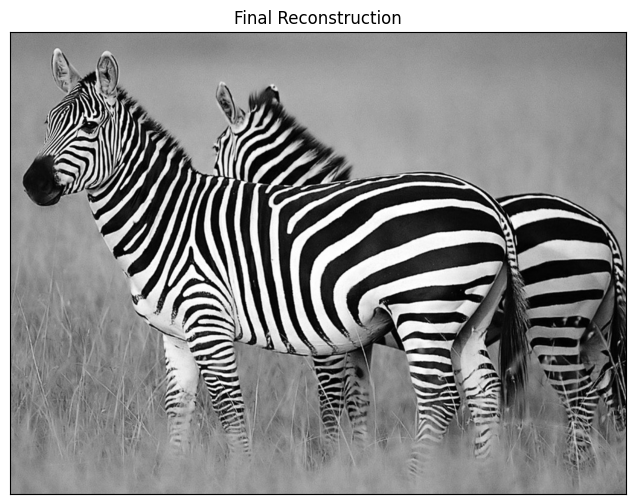

Error per pixel 0.0


In [ ]:
def reconstructLap(pyL,flagInterp):
  #A CUBRIR POR EL ALUMNADO
  return #A CUBRIR POR EL ALUMNADO

im=cv2.imread(get_image('zebra.jpg'),0)
#A CUBRIR POR EL ALUMNADO
print('Error per pixel',np.sqrt(np.mean((im - np.round(recons)) ** 2)))

# **Ejercicio 3: Imágenes Híbridas** (1.5 puntos)

Este ejercicio se basa en el siguiente trabajo: $\textit{Oliva, A., Torralba, A., & Schyns, P. G. (2006). Hybrid images. ACM Transactions on Graphics (TOG), 25(3), 527-532}$ (https://stanford.edu/class/ee367/reading/OlivaTorralb_Hybrid_Siggraph06.pdf). Vamos a aprender cómo el sistema visual humano extrae información sobre un objeto en función de la distancia. Para ello, construimos una imagen híbrida a partir de dos imágenes de objetos diferentes. Mezclando adecuadamente parte de las altas frecuencias de una imagen con parte de las bajas frecuencias de otra imagen, obtenemos una imagen híbrida que muestra diferentes percepciones con la distancia. El sigma empleado para filtrar ambas imágenes (tanto la de alta como la de bajas frecuencias) es el aspecto clave para seleccionar el rango de frecuencias altas y bajas de cada imagen. Cuanto mayor sea el valor sigma, mayor será la eliminación de altas frecuencias de la imagen. Se recomienda elegir este valor por separado para cada una de las imágenes y, de hecho, seguramente sea posible (y deseable) el tener distintos valores para distintos pares de imágenes.

Aspectos de importancia en relación a este ejercicio:

1. Como mínimo, se deben generar las imágenes híbridas correspondientes a `'cat.bmp'+'dog.bmp'`, `'submarine.bmp'+'fish.bmp'` y `'marilyn.bmp'+'einstein.bmp'` (todas ellas en escala de grises). Se debe emplear una pirámide Gaussiana con 5 niveles para mostrar el efecto obtenido.
2. No es necesario seguir al pie de la letra el artículo de referencia y operar en el dominio de la frecuencia (Fourier). Basta con operar en el dominio del espacio, como hemos hecho en todos los demás apartados de esta práctica.
3. Se debe explicar con claridad el criterio empleado para escoger la imagen de altas y la imagen de bajas frecuencias, así como el proceso seguido para filtrar la imagen de altas frecuencias y la de bajas frecuencias (incluyendo la elección de los sigmas finalmente utilizados; es decir, no sería suficiente indicar sucintamente que "se procedió por medio de prueba y error hasta obtener el sigma final").

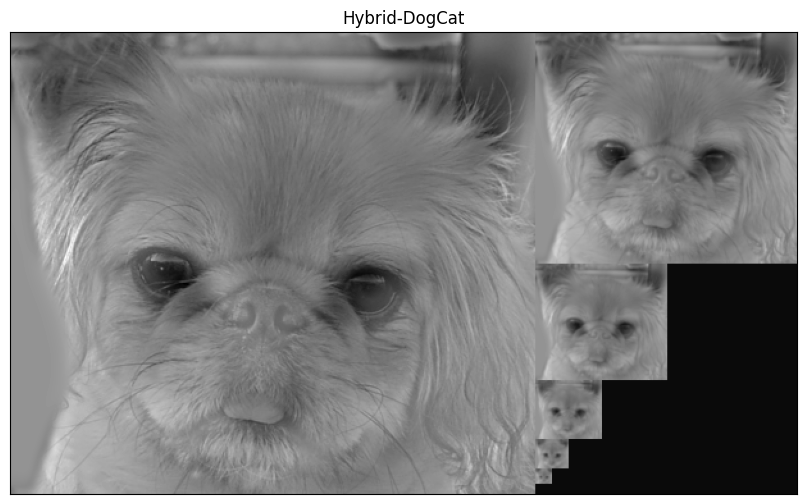

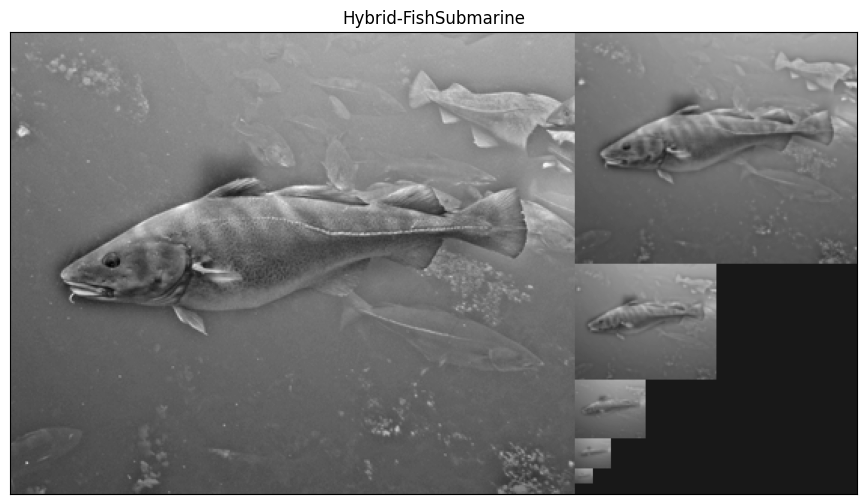

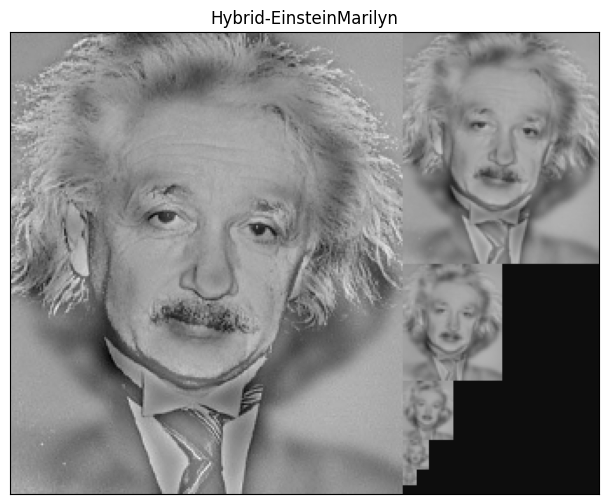

In [ ]:
#A CUBRIR POR EL ALUMNADO

# **Ejercicio 4: Pyramid Blending** (1 punto)

En este ejercicio se debe crear la imagen fusionada de la manzana (`apple.jpg`; parte superior de la imagen fusionada final) y la naranja (`orange.jpg`; parte inferior de la imagen fusionada final) empleando la técnica de $\textit{Pyramid Blending}$. Para este ejercicio, si se desea, sí se pueden emplear las funciones de OpenCV `pyrDown` y `pyrUp`.

Se debe:
1. explicar en detalle el proceso seguido a la hora de crear la nueva imagen (mezcla de ambas);
2. comparar el resultado con la combinación de las imágenes sin emplear _blending_, es decir, juntando directamente los píxeles de la mitad superior de una imagen con la mitad inferior de la otra;
3. mostrar los estados intermedios del procesado. Es decir, las pirámides Gaussianas calculadas para cada imagen (5 niveles cada una), las pirámides Laplacianas correspondientes, y los distintos niveles en que se va mezclando la imagen de salida (es decir, la reconstrucción en el nivel 1, la reconstrucción en el nivel 2,... y así sucesivamente hasta mostrar la imagen final reconstruida/_blended_).  



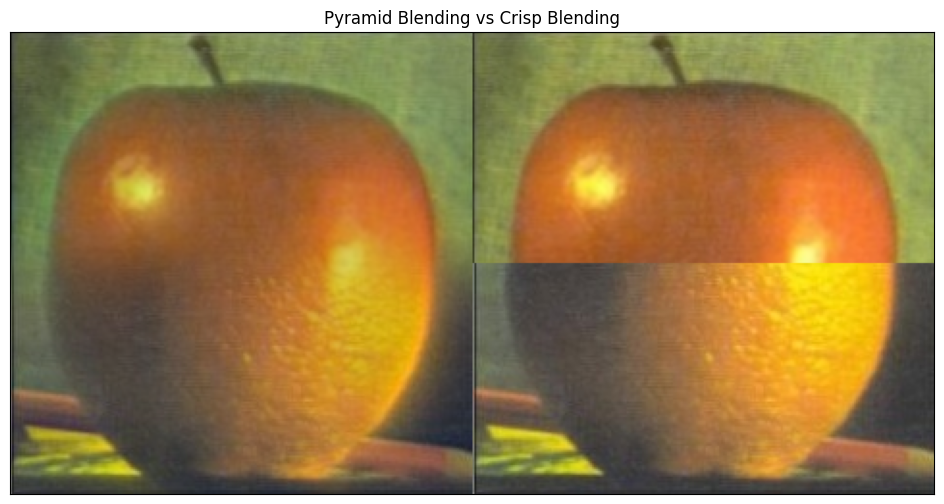

In [ ]:
#A CUBRIR POR EL ALUMNADO